### Titanic, Iris, Wine, Boston, Bank Marketing, Bank 2

In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys

import datetime, timeit, time

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.master("local").appName("titanic").enableHiveSupport().getOrCreate()

os.getcwd()

'C:\\Users\\123\\Desktop'

In [207]:
os.chdir("C:\\Users\\123\\Desktop\\")
os.getcwd()

'C:\\Users\\123\\Desktop'

In [208]:
train = pd.read_csv(r"C:\\Users\\123\\Desktop\\타이타닉\\train.csv")
test = pd.read_csv(r"C:\\Users\\123\\Desktop\\타이타닉\\test.csv")
submission = pd.read_csv(r"C:\\Users\\123\\Desktop\\타이타닉\\submission.csv")

In [209]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [210]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [211]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [212]:
train.info()
# 891 rows & 12 columns
# null data must be cleaned
# datatype already fixed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [213]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [214]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [215]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

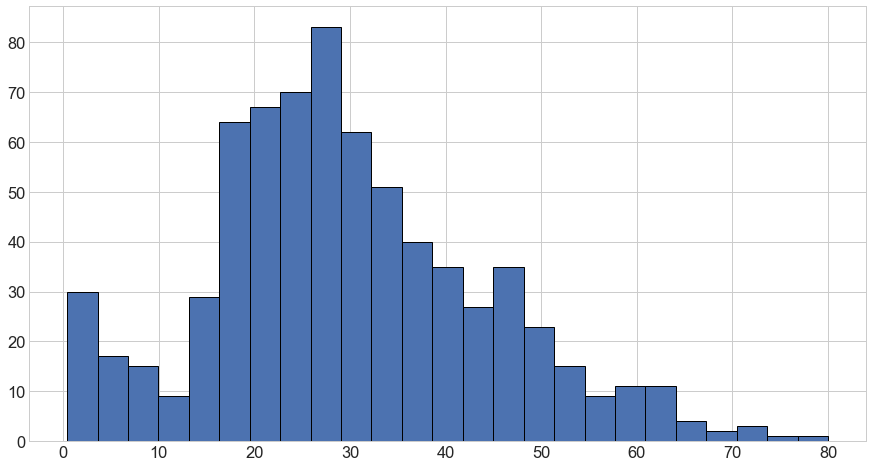

In [216]:
plt.figure(figsize=(15, 8))
train['Age'].hist(edgecolor='black', bins=25)

In [217]:
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())

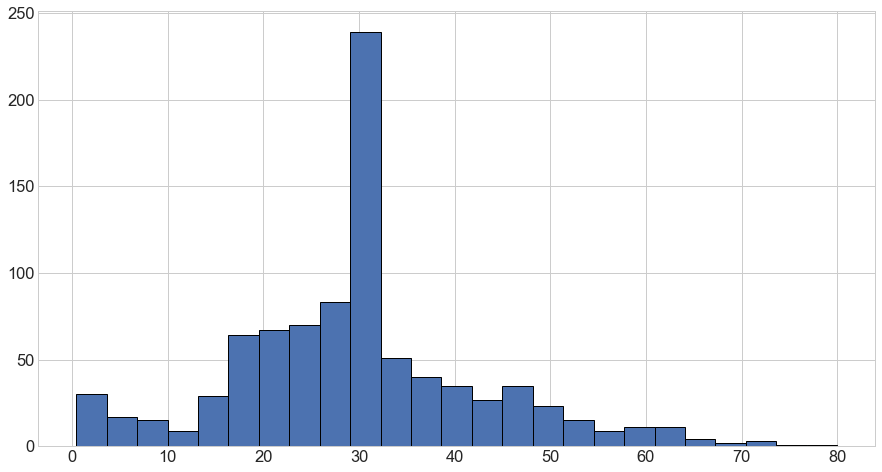

In [218]:
plt.figure(figsize=(15, 8))
train['Age'].hist(edgecolor='black', bins=25)

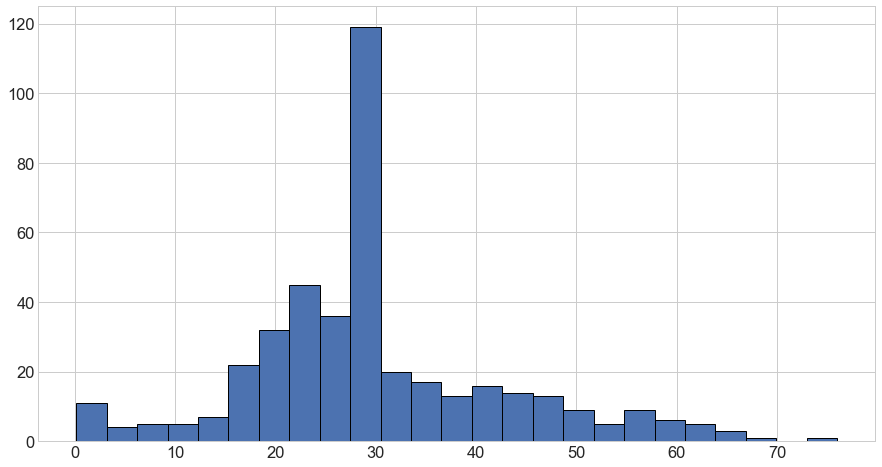

In [219]:
plt.figure(figsize=(15, 8))
test['Age'].hist(edgecolor='black', bins=25)

In [220]:
train['Sex'] = np.where(train['Sex'] == 'male', 1, 2)
test['Sex'] = np.where(test['Sex'] == 'male', 1, 2)

In [221]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [222]:
train[~((train['Embarked'] == 'C') | (train['Embarked'] == 'Q') | (train['Embarked'] == 'S'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0,B28,NaN


In [223]:
embarked_test1 = train[((train['Survived'] == 1) & (train['Pclass'] == 1) & (train['Sex'] == 2) & (train['Age'] >= 30) & (train['Age'] < 40) & (train['SibSp'] == 0))]
embarked_test1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",2,38.0,0,0,113572,80.0000,B28,NaN
218,219,1,1,"Bazzani, Miss. Albina",2,32.0,0,0,11813,76.2917,D15,C
257,258,1,1,"Cherry, Miss. Gladys",2,30.0,0,0,110152,86.5000,B77,S
258,259,1,1,"Ward, Miss. Anna",2,35.0,0,0,PC 17755,512.3292,NaN,C
269,270,1,1,"Bissette, Miss. Amelia",2,35.0,0,0,PC 17760,135.6333,C99,S
309,310,1,1,"Francatelli, Miss. Laura Mabel",2,30.0,0,0,PC 17485,56.9292,E36,C
318,319,1,1,"Wick, Miss. Mary Natalie",2,31.0,0,2,36928,164.8667,C7,S
325,326,1,1,"Young, Miss. Marie Grice",2,36.0,0,0,PC 17760,135.6333,C32,C
520,521,1,1,"Perreault, Miss. Anne",2,30.0,0,0,12749,93.5000,B73,S
537,538,1,1,"LeRoy, Miss. Bertha",2,30.0,0,0,PC 17761,106.4250,NaN,C


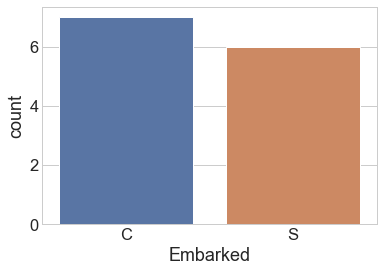

In [224]:
sns.countplot(x='Embarked', data=embarked_test1)

In [225]:
embarked_test2 = train[((train['Survived'] == 1) & (train['Pclass'] == 1) & (train['Sex'] == 2) & (train['Age'] >= 50) & (train['SibSp'] == 0))]
embarked_test2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
11,12,1,1,"Bonnell, Miss. Elizabeth",2,58.0,0,0,113783,26.5500,C103,S
195,196,1,1,"Lurette, Miss. Elise",2,58.0,0,0,PC 17569,146.5208,B80,C
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",2,58.0,0,1,PC 17582,153.4625,C125,S
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",2,50.0,0,1,PC 17558,247.5208,B58 B60,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",2,62.0,0,0,113572,80.0000,B28,NaN
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",2,56.0,0,1,11767,83.1583,C50,C


In [226]:
train['Embarked'] = train['Embarked'].fillna('C')

In [227]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 34.4+ KB


In [228]:
train['Cabin'] = train['Cabin'].fillna('C999')

In [229]:
train[train['Cabin'] == 'C999'].describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,687.0,443.208151,259.215905,1.00,214.5000,441.000000,664.5,891.0000
Survived,687.0,0.299854,0.458528,0.00,0.0000,0.000000,1.0,1.0000
Pclass,687.0,2.639010,0.589602,1.00,2.0000,3.000000,3.0,3.0000
Sex,687.0,1.315866,0.465199,1.00,1.0000,1.000000,2.0,2.0000
Age,687.0,28.048341,11.854156,0.42,21.5000,29.699118,32.0,74.0000
SibSp,687.0,0.547307,1.207492,0.00,0.0000,0.000000,1.0,8.0000
Parch,687.0,0.365357,0.827106,0.00,0.0000,0.000000,0.0,6.0000
Fare,687.0,19.157325,28.663343,0.00,7.8771,10.500000,23.0,512.3292


In [230]:
train[train['Cabin'] == 'C999']['Sex'].value_counts()

1    470
2    217
Name: Sex, dtype: int64

In [231]:
print(f"C999 Male ratio:\t {470 / 687 * 100:.1f}%")
print(f"C999 Female ratio:\t {217 / 687 * 100:.1f}%")

C999 Male ratio:	 68.4%
C999 Female ratio:	 31.6%


In [232]:
train[train['Cabin'] != 'C999']['Sex'].value_counts()

1    107
2     97
Name: Sex, dtype: int64

In [233]:
print(f"Male ratio:\t {107 / 204 * 100:.1f}%")
print(f"Female ratio:\t {97 / 204 * 100:.1f}%")

Male ratio:	 52.5%
Female ratio:	 47.5%


28.0483414675914


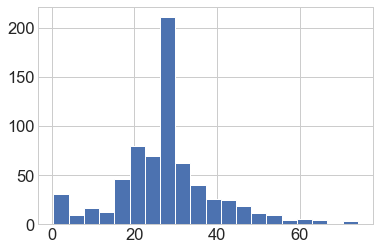

In [234]:
train[train['Cabin'] == 'C999']['Age'].hist(bins=20)
print(train[train['Cabin'] == 'C999']['Age'].mean())

35.258349192618226


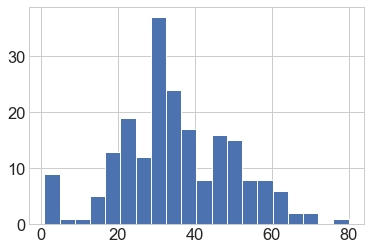

In [235]:
train[train['Cabin'] != 'C999']['Age'].hist(bins=20)
print(train[train['Cabin'] != 'C999']['Age'].mean())

In [236]:
train[train['Cabin'] != 'C999']['Cabin'].value_counts()
# 25~35 years-old
# male 6 : female 4

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
F33            3
D              3
E101           3
C22 C26        3
B5             2
B58 B60        2
E33            2
B35            2
F4             2
B20            2
B22            2
F G73          2
B28            2
C123           2
C52            2
C126           2
E24            2
E67            2
C2             2
E8             2
C83            2
D35            2
B49            2
E121           2
E25            2
D33            2
              ..
C103           1
D19            1
E63            1
C90            1
D15            1
B37            1
E40            1
C30            1
C49            1
E10            1
F38            1
B94            1
E46            1
E12            1
A24            1
A7             1
D48            1
C45            1
D46            1
E49            1
A16            1
C99            1
D7             1
B101           1
A34            1
B3             1
D9             1
A32           

In [237]:
test['Cabin'] = test['Cabin'].fillna('C999')

In [238]:
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [239]:
train.isna().sum().sum()

0

In [240]:
test.isna().sum().sum()

0

In [241]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,C999,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,C999,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,C999,S


In [242]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,C999,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.0,1,0,363272,7.0000,C999,S
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,C999,Q
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,C999,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.0,1,1,3101298,12.2875,C999,S


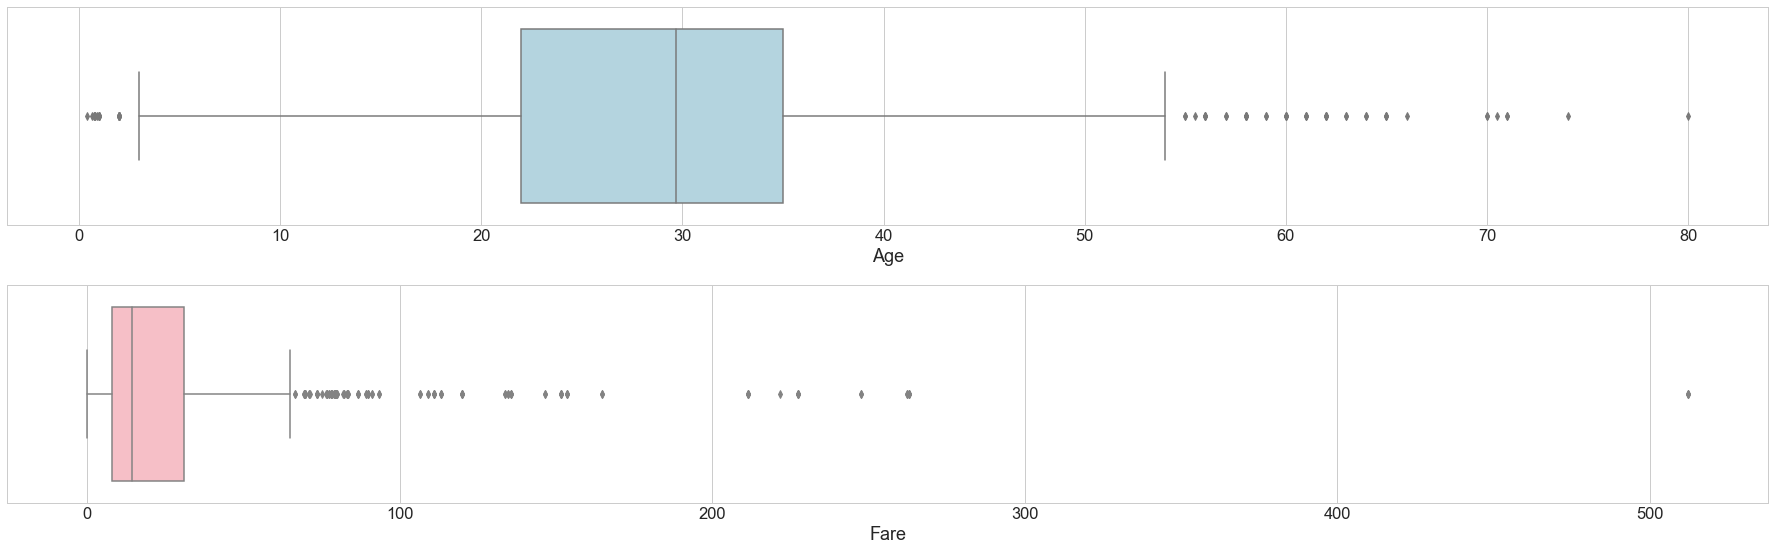

In [243]:
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 8))
sns.boxplot(x='Age', data=train, color='lightblue', ax=ax[0])
sns.boxplot(x='Fare', data=train, color='lightpink', ax=ax[1])

plt.tight_layout()
plt.show()

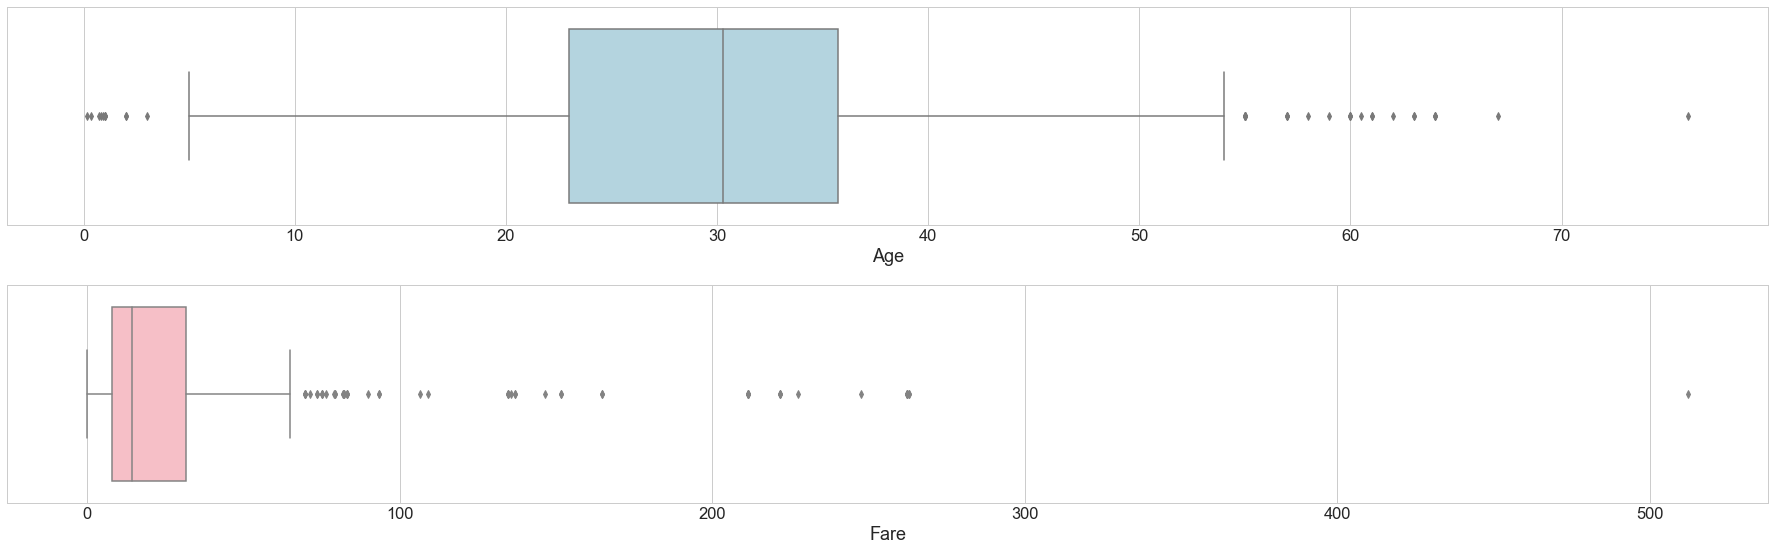

In [244]:
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 8))
sns.boxplot(x='Age', data=test, color='lightblue', ax=ax[0])
sns.boxplot(x='Fare', data=test, color='lightpink', ax=ax[1])

plt.tight_layout()
plt.show()

In [245]:
train = train.drop(['Name', 'Ticket'], axis=1)
test = test.drop(['Name', 'Ticket'], axis=1)

In [246]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,7.2500,C999,S
1,2,1,1,2,38.0,1,0,71.2833,C85,C
2,3,1,3,2,26.0,0,0,7.9250,C999,S
3,4,1,1,2,35.0,1,0,53.1000,C123,S
4,5,0,3,1,35.0,0,0,8.0500,C999,S


In [247]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,1,34.5,0,0,7.8292,C999,Q
1,893,3,2,47.0,1,0,7.0000,C999,S
2,894,2,1,62.0,0,0,9.6875,C999,Q
3,895,3,1,27.0,0,0,8.6625,C999,S
4,896,3,2,22.0,1,1,12.2875,C999,S


In [248]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [249]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,S
1,2,1,1,2,38.0,1,0,71.2833,C
2,3,1,3,2,26.0,0,0,7.9250,S
3,4,1,1,2,35.0,1,0,53.1000,S
4,5,0,3,1,35.0,0,0,8.0500,S


In [250]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,Q
1,893,3,2,47.0,1,0,7.0000,S
2,894,2,1,62.0,0,0,9.6875,Q
3,895,3,1,27.0,0,0,8.6625,S
4,896,3,2,22.0,1,1,12.2875,S


In [251]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(train[['Embarked']])
ohe_transformed = ohe.transform(train[['Embarked']])

In [252]:
embarked_ohe = pd.DataFrame(ohe_transformed, columns=['Embarked_C', 'Embarked_Q', 'Embarked_S'])

In [253]:
train = pd.concat([train, embarked_ohe], axis=1)

In [255]:
train = train.drop(['Embarked'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,2,1,1,2,38.0,1,0,71.2833,1.0,0.0,0.0
2,3,1,3,2,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,2,35.0,1,0,53.1000,0.0,0.0,1.0
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [257]:
from sklearn.model_selection import train_test_split

feature = train.drop(['Survived'], axis=1)
label = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2, stratify=label)

In [259]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

712
179
712
179


In [261]:
X_train = X_train.drop('PassengerId', axis=1)
X_val = X_val.drop('PassengerId', axis=1)

In [262]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
364,3,1,29.699118,1,0,15.5000,0.0,1.0,0.0
708,1,2,22.000000,0,0,151.5500,0.0,0.0,1.0
803,3,1,0.420000,0,1,8.5167,1.0,0.0,0.0
359,3,2,29.699118,0,0,7.8792,0.0,1.0,0.0
797,3,2,31.000000,0,0,8.6833,0.0,0.0,1.0


In [263]:
X_val.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
537,1,2,30.0,0,0,106.4250,1.0,0.0,0.0
182,3,1,9.0,4,2,31.3875,0.0,0.0,1.0
88,1,2,23.0,3,2,263.0000,0.0,0.0,1.0
883,2,1,28.0,0,0,10.5000,0.0,0.0,1.0
634,3,2,9.0,3,2,27.9000,0.0,0.0,1.0


In [264]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier 

In [267]:
dct = DecisionTreeClassifier(min_samples_leaf=30)
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()
gbm = LGBMClassifier()
ann = MLPClassifier()

In [268]:
import warnings
warnings.filterwarnings('ignore')

dct.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
xgb.fit(X_train, y_train)
gbm.fit(X_train, y_train)
ann.fit(X_train, y_train)

[16:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [269]:
pred_proba_dct = dct.predict_proba(X_val)
pred_proba_rfc = rfc.predict_proba(X_val)
pred_proba_gbc = gbc.predict_proba(X_val)
pred_proba_xgb = xgb.predict_proba(X_val)
pred_proba_gbm = gbm.predict_proba(X_val)
pred_proba_ann = ann.predict_proba(X_val)

pred_proba_num_dct = pred_proba_dct[:,1]
pred_proba_num_rfc = pred_proba_rfc[:,1]
pred_proba_num_gbc = pred_proba_gbc[:,1]
pred_proba_num_xgb = pred_proba_xgb[:,1]
pred_proba_num_gbm = pred_proba_gbm[:,1]
pred_proba_num_ann = pred_proba_ann[:,1]

pred_dct = dct.predict(X_val)
pred_rfc = rfc.predict(X_val)
pred_gbc = gbc.predict(X_val)
pred_xgb = xgb.predict(X_val)
pred_gbm = gbm.predict(X_val)
pred_ann = ann.predict(X_val)

In [276]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

model_list = [pred_dct, pred_rfc, pred_gbc, pred_xgb, pred_gbm, pred_ann]
model_name = ['DECISION TREE', 'RANDOM FOREST', 'GRADIENT BOOST', 'XG BOOST', 'LIGHT GBM', 'NEURAL NETWORK']

for pred, name in zip(model_list, model_name):
    print('='*50)
    print(f'MODEL: {name}')
    print('-'*50)
    print('METRICS')
    print(f'Accuracy:\t {accuracy_score(y_val, pred):.4f}')
    print(f'Precision:\t {precision_score(y_val, pred):.4f}')
    print(f'Recall:\t\t {recall_score(y_val, pred):.4f}')
    print(f'F1:\t\t {f1_score(y_val, pred):.4f}')
    print('-'*50)
    print('CONFUSON MATRIX')
    print(confusion_matrix(y_val, pred))
    print('-'*50)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_val, pred))


MODEL: DECISION TREE
--------------------------------------------------
METRICS
Accuracy:	 0.8045
Precision:	 0.8148
Recall:		 0.6377
F1:		 0.7154
--------------------------------------------------
CONFUSON MATRIX
[[100  10]
 [ 25  44]]
--------------------------------------------------
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       110
           1       0.81      0.64      0.72        69

   micro avg       0.80      0.80      0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179

MODEL: RANDOM FOREST
--------------------------------------------------
METRICS
Accuracy:	 0.8492
Precision:	 0.8088
Recall:		 0.7971
F1:		 0.8029
--------------------------------------------------
CONFUSON MATRIX
[[97 13]
 [14 55]]
--------------------------------------------------
CLASSIFICATION REPORT
              precision    recall  f1-score   support

  

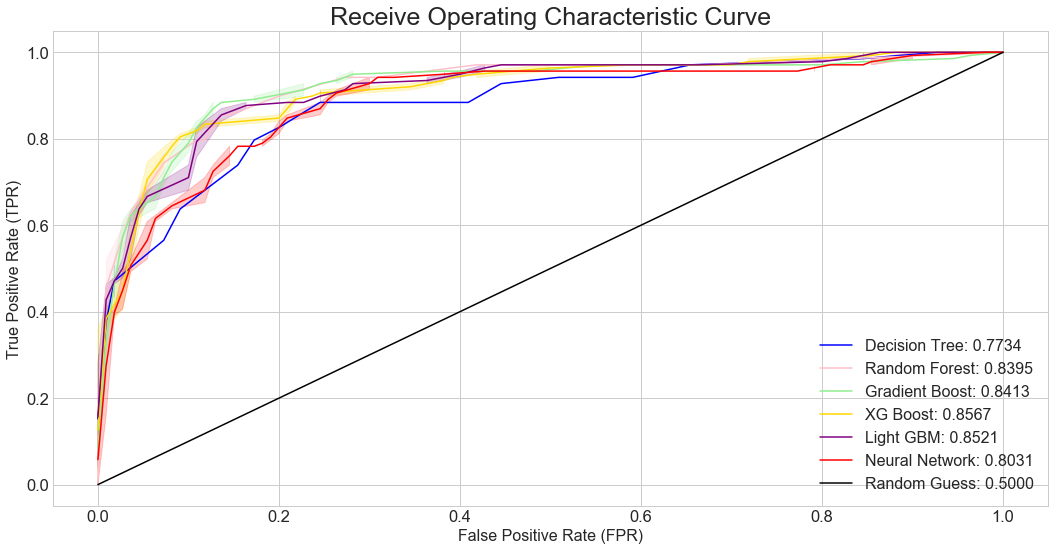

In [286]:
plt.style.use('seaborn-whitegrid')

fpr_dct, tpr_dct, threshold = roc_curve(y_val, pred_proba_num_dct)
fpr_rfc, tpr_rfc, threshold = roc_curve(y_val, pred_proba_num_rfc)
fpr_gbc, tpr_gbc, threshold = roc_curve(y_val, pred_proba_num_gbc)
fpr_xgb, tpr_xgb, threshold = roc_curve(y_val, pred_proba_num_xgb)
fpr_gbm, tpr_gbm, threshold = roc_curve(y_val, pred_proba_num_gbm)
fpr_ann, tpr_ann, threshold = roc_curve(y_val, pred_proba_num_ann)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.lineplot(x=fpr_dct, y=tpr_dct, color='blue', ax=ax, label=f'Decision Tree: {roc_auc_score(y_val, pred_dct):.4f}')
sns.lineplot(x=fpr_rfc, y=tpr_rfc, color='pink', ax=ax, label=f'Random Forest: {roc_auc_score(y_val, pred_rfc):.4f}')
sns.lineplot(x=fpr_gbc, y=tpr_gbc, color='lightgreen', ax=ax, label=f'Gradient Boost: {roc_auc_score(y_val, pred_gbc):.4f}')
sns.lineplot(x=fpr_xgb, y=tpr_xgb, color='gold', ax=ax, label=f'XG Boost: {roc_auc_score(y_val, pred_xgb):.4f}')
sns.lineplot(x=fpr_gbm, y=tpr_gbm, color='purple', ax=ax, label=f'Light GBM: {roc_auc_score(y_val, pred_gbm):.4f}')
sns.lineplot(x=fpr_ann, y=tpr_ann, color='red', ax=ax, label=f'Neural Network: {roc_auc_score(y_val, pred_ann):.4f}')

sns.lineplot([0,1], [0,1], color='black', ax=ax, label='Random Guess: 0.5000')

ax.set_title("Receive Operating Characteristic Curve", fontsize=25)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=16)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=16)

ax.legend(loc=4, fontsize=16)
plt.tight_layout()
plt.show()

In [289]:
ohe.fit(test[['Embarked']])
test_cat_col_transformed = ohe.transform(test[['Embarked']])

In [291]:
embarked_test_ohe = pd.DataFrame(test_cat_col_transformed, columns=['Embarked_C', 'Embarked_Q', 'Embarked_S'])
embarked_test_ohe

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
6,0.0,1.0,0.0
7,0.0,0.0,1.0
8,1.0,0.0,0.0
9,0.0,0.0,1.0


In [292]:
test = pd.concat([test, embarked_test_ohe], axis=1)

In [294]:
test = test.drop('Embarked', axis=1)

In [296]:
test2 = test.copy()

In [297]:
test = test.drop('PassengerId', axis=1)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,2,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,2,22.0,1,1,12.2875,0.0,0.0,1.0


In [309]:
test2.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,892,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,893,3,2,47.0,1,0,7.0000,0.0,0.0,1.0
2,894,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,895,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,896,3,2,22.0,1,1,12.2875,0.0,0.0,1.0


In [331]:
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [335]:
from sklearn.model_selection import RandomizedSearchCV

params_dist = {'bootstrap': [True],
               'criterion': ['gini'],
               'max_depth': [5,7,9,11],
               'max_features': ['auto'],
               'min_samples_leaf': [1, 2, 3],
               'min_samples_split': [2, 4, 6],
               'n_estimators': [100, 300, 500],
               'n_jobs': [-1],
               'random_state': [1234],
               'verbose': [0, 1, 2]
              }

randsearch = RandomizedSearchCV(rfc, 
                         param_distributions=params_dist, # 파라미터 입력
                         n_iter = 100,                    # random search 탐색 횟수
                         cv = 5,                          # cv 검증을 위한 분할 검증 횟수
                         scoring='accuracy',              # 오차 평가방법
                         verbose=1,                       # 진행상황
                        )

randsearch.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s f

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | el

[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 50

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using bac

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using bac

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend Thre

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out o

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend Thre

[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 50

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend Thre

[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | el

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent wo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent wo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent wo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend Thre

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'bootstrap': [True], 'criterion': ['gini'], 'max_depth': [5, 7, 9, 11], 'max_features': ['auto'], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 'n_estimators': [100, 300, 500], 'n_jobs': [-1], 'random_state': [1234], 'verbose': [0, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=1)

In [336]:
print('최적 하이퍼파라미터: ', randsearch.best_params_)
y_val_pred = randsearch.predict(X_val)
print('검증 정확도:', randsearch.best_score_)
print('F1:',f1_score(y_val, y_val_pred))

최적 하이퍼파라미터:  {'verbose': 1, 'random_state': 1234, 'n_jobs': -1, 'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini', 'bootstrap': True}


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished


검증 정확도: 0.8202247191011236
F1: 0.7812499999999999


In [339]:
rfc2 = RandomForestClassifier(verbose=1, random_state=1234, n_jobs=-1, n_estimators=300, min_samples_split=6, \
                              min_samples_leaf=1, max_features='auto', max_depth=7, criterion='gini', bootstrap=True)
rfc2.fit(X_train, y_train)

pred_proba_rfc2 = rfc2.predict_proba(X_val)
pred_proba_num_rfc2 = pred_proba_rfc2[:,1]
pred_rfc2 = rfc2.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished


In [340]:
print(f'Accuracy:\t {accuracy_score(y_val, pred_rfc2):.4f}')
print(f'Precision:\t {precision_score(y_val, pred_rfc2):.4f}')
print(f'Recall:\t\t {recall_score(y_val, pred_rfc2):.4f}')
print(f'F1:\t\t {f1_score(y_val, pred_rfc2):.4f}')
print('-'*50)
print('CONFUSON MATRIX')
print(confusion_matrix(y_val, pred_rfc2))
print('-'*50)
print('CLASSIFICATION REPORT')
print(classification_report(y_val, pred_rfc2))

# Accuracy:	 0.8492
# Precision:	 0.8088
# Recall:		 0.7971
# F1:		 0.8029

# Accuracy:	 0.8603
# Precision:	 0.8235
# Recall:		 0.8116
# F1:		 0.8175

Accuracy:	 0.8436
Precision:	 0.8475
Recall:		 0.7246
F1:		 0.7812
--------------------------------------------------
CONFUSON MATRIX
[[101   9]
 [ 19  50]]
--------------------------------------------------
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       110
           1       0.85      0.72      0.78        69

   micro avg       0.84      0.84      0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



In [350]:
pred_proba_rfc2 = rfc2.predict_proba(test)
pred_proba_num_rfc2 = pred_proba_rfc2[:,1]
pred_rfc2 = rfc2.predict(test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


In [354]:
submission = pd.DataFrame({'PassengerId':test2['PassengerId'] , 'Survived':pred_rfc2})

In [356]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [360]:
submission.to_csv("C:\\Users\\123\\Desktop\\submission.csv", index=False)

In [369]:
xgb2 = XGBClassifier()
xgb2.fit(X_train, y_train)

pred_proba_xgb2 = xgb2.predict_proba(X_val)
pred_proba_num_xgb2 = pred_proba_xgb2[:,1]
pred_xgb2 = xgb2.predict(X_val)

[18:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [370]:
print(f'Accuracy:\t {accuracy_score(y_val, pred_xgb2):.4f}')
print(f'Precision:\t {precision_score(y_val, pred_xgb2):.4f}')
print(f'Recall:\t\t {recall_score(y_val, pred_xgb2):.4f}')
print(f'F1:\t\t {f1_score(y_val, pred_xgb2):.4f}')
print('-'*50)
print('CONFUSON MATRIX')
print(confusion_matrix(y_val, pred_xgb2))
print('-'*50)
print('CLASSIFICATION REPORT')
print(classification_report(y_val, pred_xgb2))

Accuracy:	 0.8603
Precision:	 0.8056
Recall:		 0.8406
F1:		 0.8227
--------------------------------------------------
CONFUSON MATRIX
[[96 14]
 [11 58]]
--------------------------------------------------
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       110
           1       0.81      0.84      0.82        69

   micro avg       0.86      0.86      0.86       179
   macro avg       0.85      0.86      0.85       179
weighted avg       0.86      0.86      0.86       179



In [371]:
pred_proba_xgb2 = xgb2.predict_proba(test)
pred_proba_num_xgb2 = pred_proba_xgb2[:,1]
pred_xgb2 = xgb2.predict(test)

In [372]:
submission = pd.DataFrame({'PassengerId':test2['PassengerId'] , 'Survived':pred_xgb2})

In [373]:
submission.to_csv("C:\\Users\\123\\Desktop\\submission.csv", index=False)